# Finding the Max Sharpe Ratio Portfolio!

In [9]:
%load_ext autoreload
%autoreload 2

import edhec_risk_kit as erk
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\edhec_risk_kit.py:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("ind30_m_rets.csv",


In [12]:
# we will use a quadratic optimizer that is built into scipy to define a custom function for the portfolio with the max sharpe ratio
from scipy.optimize import minimize
import numpy as np
import pandas as pd
def msr(riks_free_rate, er, cov):
    """
    Risk free rate + ER + Cov --> weights
    """
    n = er.shape[0] # number of assets is the same as the number of rows in the expected returns array
    init_guess = np.repeat(1/n, n) #weights are inialized to be equal weights for all n assets
    bounds = ((0.0, 1.0),)*n  # specifies the bounds as an n-tuple of the lower (0%) and upper (100%) bounds for the weights
    
    weights_sum_to_1 = {
        'type': 'eq', # equality constraint
        'fun': lambda weights: np.sum(weights) - 1
    }

    def neg_sharpe_ratio(weights, risk_free_rate, er, cov):
        """
        Returns the negative of the Sharpe Ratio, given weights, exected returns and covariance matrix
        """
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r-risk_free_rate)/vol

    results = minimize(neg_sharpe_ratio, init_guess, #minimize the negative of the Sharpe ratio
                       args=(riks_free_rate, er, cov,), method="SLSQP", # quadratic programming optimizer
                       options={'disp': False},  # set display to false to avoid results cluttering the screen
                       constraints=(weights_sum_to_1), # set the constraints
                       bounds=bounds
                       )
    return results.x #passes the results to a variable called x


(0.0, 0.14197783788622648)

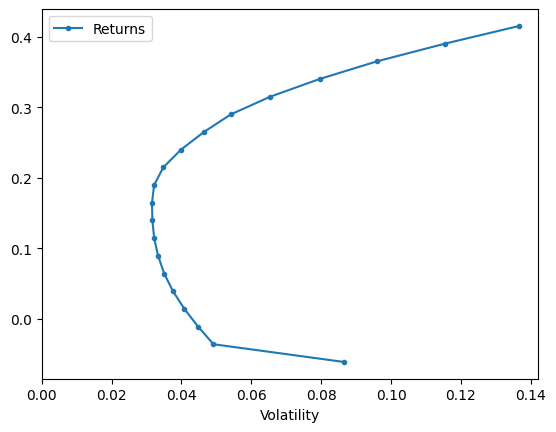

In [5]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left=0)

Next, we will specify our risk free rate, say 10%. That would be the point 0.1 on the x-axis. We will plot the line starting from that point, that is tangential to the eff frontier curve (Capital Market Line or CML)

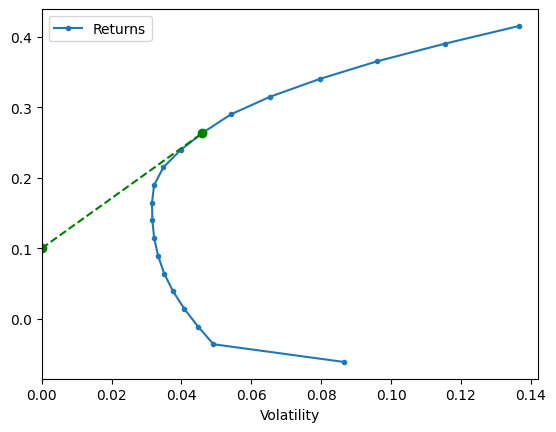

In [13]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left=0)
rf = 0.1
w_msr = msr(rf, er, cov) #weights of the max Sharpe ratio portfolio
r_msr = erk.portfolio_return(w_msr, er) #return of the max Sharpe ratio portfolio
vol_msr = erk.portfolio_vol(w_msr, cov) #vol of the max Sharpe ratio portfolio

# Add the CML to the plot
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color = "green", marker="o", linestyle="dashed")

We'll enhance our function plot_ef in the erk module by adding the CML feature, plus we will add the new function msr to erk.

<Axes: xlabel='Volatility'>

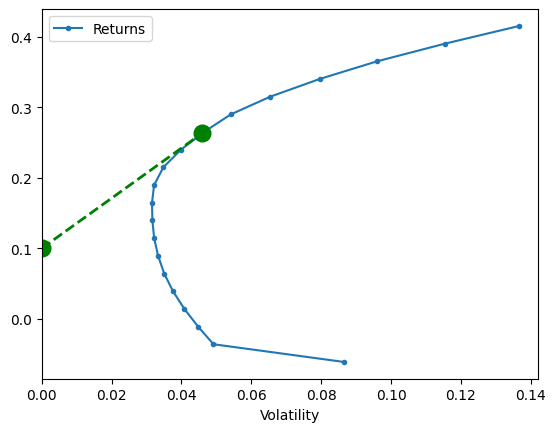

In [15]:
erk.plot_ef(20, er, cov, show_cml=True, risk_free_rate=0.1) #risk free rate is set to zero by default if it is not specified